<a href="https://colab.research.google.com/github/saurabhmathur96/Masters-Thesis/blob/master/uncertainty_in_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from os import path
import torch
from torchvision import transforms, datasets


datasets.MNIST('data/',
    train=True,
    download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))


0it [00:00, ?it/s]

100%|█████████▉| 9871360/9912422 [00:23<00:00, 854881.42it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 128744.45it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



 94%|█████████▍| 1548288/1648877 [00:02<00:00, 981283.60it/s]
1654784it [00:02, 729125.32it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 47783.91it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [0]:
from torch import nn

def EpistemicNN(input_size, output_size, hidden_size, hidden_count):
  layers = []
  layers.append(nn.Linear(input_size, hidden_size))
  layers.append(nn.Dropout(.2))
  layers.append(nn.ReLU())
  
  for i in range(hidden_count):
    layers.append(nn.Linear(hidden_size, hidden_size))
    layers.append(nn.Dropout(.2))
    layers.append(nn.ReLU())
  
  layers.append(nn.Linear(hidden_size, output_size))
  layers.append(nn.LogSoftmax(dim=1))
  return nn.Sequential(*layers)

def init_weights(m):
  if type(m) == nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

net = EpistemicNN(28*28, 10, 1024, 3)
net.apply(init_weights)

from tqdm.auto import tqdm
from torch.autograd import Variable

X, y = torch.load(path.join('data', 'MNIST', 'processed', 'training.pt'))
X = X.reshape(len(X), -1)
train = torch.utils.data.TensorDataset(X, y)
train =torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters())

for (data, target) in tqdm(train, total=int(len(X)/128)):
  data = Variable(data).float()
  target = Variable(target)
  optimizer.zero_grad()
  output = net(data)
  loss = criterion(output, target)
  loss.backward()
  optimizer.step()

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=1024, bias=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=10, bias=True)
  (13): LogSoftmax()
)

In [0]:
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal

import torch.nn.functional as F


def FFLayers(input_size, output_size, hidden_size, hidden_count):
  layers = []
  layers.append(nn.Linear(input_size, hidden_size))
  layers.append(nn.ReLU())
  
  for i in range(hidden_count):
      layers.append(nn.Linear(hidden_size, hidden_size))
      layers.append(nn.ReLU())
  
  layers.append(nn.Linear(hidden_size, output_size))
  return layers

class AleatoricNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, hidden_count):
    super(AleatoricNN, self).__init__()
    
    args = (input_size, output_size, hidden_size, hidden_count)

    self.mu = nn.Sequential(*FFLayers(*args))
    args = (input_size, 1, hidden_size, hidden_count)
    self.log_sigma2 = nn.Sequential(*FFLayers(*args))
  
  def forward(self, x):
    return self.mu(x), self.log_sigma2(x)

def init_weights(m):
  if type(m) == nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

class AleatoricLoss(torch.nn.Module):
    def __init__(self, class_count=10, T=25):
        super(AleatoricLoss,self).__init__()
        self.nllloss = nn.NLLLoss()
        self.mvn = MultivariateNormal(torch.zeros(class_count), torch.eye(class_count))
        self.T = T
        self.class_count = class_count
        
    def forward(self, mu, log_sigma2, y):
        loss = []

        for t in range(self.T):
          x = torch.zeros_like(mu)
          
          for i, xi in enumerate(x):
            e = self.mvn.sample()
            #print (e)
            x[i] = mu[i] +  torch.exp(log_sigma2[i]) * e
          #print (-F.cross_entropy(x, y, reduction='none'))
          #print (torch.exp(-F.cross_entropy(x, y, reduction='none')))
          #print (x)
          #print (F.softmax(x, dim=1)[:, y])
          loss.append(F.cross_entropy(x, y, reduction='none') - np.log(self.T) )
          #print (loss)
       
        loss = torch.stack( tuple(loss) )
        
        return sum(torch.logsumexp(loss, dim=0) )# - torch.log(torch.Tensor(self.T)))
      
import numpy as np
X, y = torch.load(path.join('data', 'MNIST', 'processed', 'training.pt'))
X = X.reshape(len(X), -1)
train = torch.utils.data.TensorDataset(X, y)
train =torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

net = AleatoricNN(28*28, 10, 1024, 5)
net.apply(init_weights)
criterion = AleatoricLoss()


from tqdm.auto import tqdm
from torch.autograd import Variable

optimizer = torch.optim.Adam(net.parameters())
X, y = torch.load(path.join('data', 'MNIST', 'processed', 'test.pt'))
X = Variable(X).reshape(len(X), -1).float()
y = Variable(y)


for it in range(5):
  for i, (data, target) in tqdm(enumerate(train),total=len(train)):
    data = Variable(data).float()
    target = Variable(target)
    optimizer.zero_grad()
    output = net(data)
    loss = criterion(*output, target)
    loss.backward()
    optimizer.step()

  log_mu, log_sigma2 = net(X)
  print ((torch.argmax(log_mu, axis=1) == y).sum().float()/len(y))


tensor(0.9571)


tensor(0.9691)


tensor(0.9675)


tensor(0.9710)


tensor(0.9726)


In [0]:
X, y = torch.load(path.join('data', 'MNIST', 'processed', 'test.pt'))
X = Variable(X).reshape(len(X), -1).float()
y = Variable(y)
log_mu, log_sigma2 = net(X)

In [0]:
(torch.argmax(log_mu, axis=1) == y).sum().float()/len(y)

tensor(0.9726)

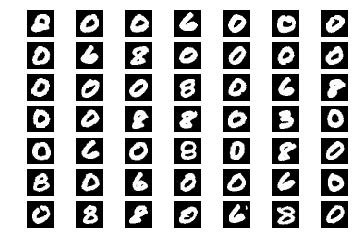

In [0]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline

count = 0
u = []
p = []
for i, (yi, log_mui, log_sigma2i) in sorted(enumerate(zip(y, log_mu, log_sigma2)), key=lambda x: x[1][-1]):
  #print (i, yi, F.softmax(log_mui, dim=0), log_sigma2i)
  u.append(i)
  p.append(F.softmax(log_mui, dim=0).argmax())
  #print(log_sigma2i)
  count += 1
  if count == 7*7:
    break

for i, index in enumerate(u):
  plt.subplot(7, 7, i+1)
  plt.imshow(X[index].reshape((28,28)), cmap='gray')
  plt.axis('off')

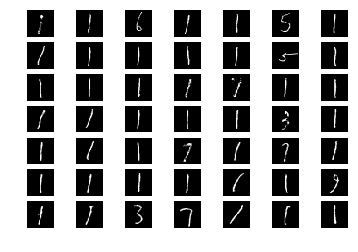

In [0]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline

count = 0
u = []
p = []
for i, (yi, log_mui, log_sigma2i) in sorted(enumerate(zip(y, log_mu, log_sigma2)), key=lambda x: x[1][-1], reverse=True):
  #print (i, yi, F.softmax(log_mui, dim=0), log_sigma2i)
  u.append(i)
  p.append(F.softmax(log_mui, dim=0).argmax())
  # print(log_sigma2i)
  count += 1
  if count == 7*7:
    break

for i, index in enumerate(u):
  plt.subplot(7, 7, i+1)
  plt.imshow(X[index].reshape((28,28)), cmap='gray')
  plt.axis('off')

In [0]:
log_sigma2

tensor([[-27407.9648],
        [-29638.8477],
        [-19004.2402],
        ...,
        [-44308.4805],
        [-35253.3945],
        [-42013.6719]], grad_fn=<AddmmBackward>)

In [0]:
#mvn  = MultivariateNormal(torch.zeros(10), torch.eye(10))

help(mvn.sample)
mvn.sample(sample_shape=(4,))

Help on method sample in module torch.distributions.distribution:

sample(sample_shape=torch.Size([])) method of torch.distributions.multivariate_normal.MultivariateNormal instance
    Generates a sample_shape shaped sample or sample_shape shaped batch of
    samples if the distribution parameters are batched.



tensor([[-1.6443, -0.0646,  1.0144, -0.2379, -0.3619,  0.3627,  0.7214,  0.5548,
          0.2018,  0.6938],
        [-2.0725,  1.3966, -0.0757, -0.7647, -0.0178,  0.5236,  0.2136, -0.5268,
          0.7902,  0.0564],
        [-0.8907, -0.0943,  0.4434,  0.9981, -0.5429,  0.6034, -0.5512,  0.8614,
          0.2924,  0.3477],
        [ 0.9902,  0.8010, -0.2010,  0.0977,  0.0080, -1.0446, -0.1039,  1.1018,
         -0.8353, -0.2125]])

In [0]:
X, y = torch.load(path.join('data', 'MNIST', 'processed', 'test.pt'))
X = Variable(X).reshape(len(X), -1).float()
y = Variable(y)
ps = [torch.exp(net(X)).detach() for _ in range(50)]


In [0]:
ps = [p.numpy() for p in ps]

In [0]:
means = [sum(ps[i][j] for i in range(50))/50 for j in range(len(X))]

In [0]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline
count = 0
indices = []
for i, m in sorted(enumerate(means), key=lambda x: entropy(x[1]), reverse=True):
  print (i, entropy(m))
  indices.append(i)
  count += 1

  if count == 16:
    break

3030 2.247729
6560 2.2402413
4477 2.2339535
4814 2.2145092
4248 2.2078953
6651 2.1958096
3951 2.1953404
9858 2.1884315
2118 2.1835096
4145 2.1581554
1969 2.1533823
543 2.1473057
800 2.1171322
3225 2.1063507
3060 2.105475
6112 2.1048436


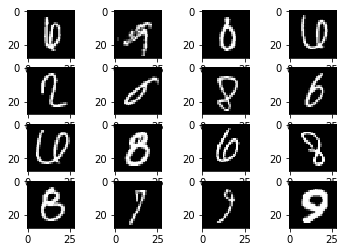

In [0]:

for i, index in enumerate(indices):
  plt.subplot(4, 4, i+1)
  plt.imshow(X[index].reshape((28,28)), cmap='gray')

In [0]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline
count = 0
indices = []
for i, m in sorted(enumerate(means), key=lambda x: entropy(x[1]), reverse=False):
  print (i, entropy(m))
  indices.append(i)
  count += 1

  if count == 16:
    break

6789 6.433324e-14
7175 2.0679294e-12
6068 2.2930872e-12
3584 2.8511635e-12
8619 3.3760395e-12
972 9.9492446e-12
8976 1.4145138e-11
8179 1.858648e-11
8988 1.8799335e-11
1457 2.857509e-11
3603 2.9240593e-11
8657 3.8931244e-11
6748 9.0640204e-11
8468 1.0469398e-10
4628 1.0624445e-10
1820 1.2579993e-10


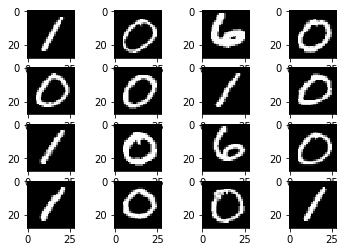

In [0]:

for i, index in enumerate(indices):
  plt.subplot(4, 4, i+1)
  plt.imshow(X[index].reshape((28,28)), cmap='gray')